# Collaborative filtering

In [1]:
from functools import reduce
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Dot, Concatenate
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model

pd.set_option('display.max_columns', None)

def save(obj, path):
    with open(path, 'bw') as file:
        pickle.dump(obj, file)

def load(path):
    with open(path, 'br') as file:
        return pickle.load(file)

def missing(df):
    return df[df.isna().any(axis='columns')]

def chain_layers(*layers):
    return reduce(lambda output, layer: layer(output), layers)

def plot_loss(history):
    n_epoch = len(history['loss'])
    xs = np.arange(1, n_epoch + 1)
    fig, ax = plt.subplots()
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.plot(xs, history['loss'], label='Train')
    ax.plot(xs, history['val_loss'], label='Validation')
    ax.legend()
    return fig

def plot_acc(history):
    n_epoch = len(history['accuracy'])
    xs = np.arange(1, n_epoch + 1)
    fig, [loss, acc] = plt.subplots(2, 1, sharex=True)
    fig.subplots_adjust(hspace=0)
    loss.set_ylabel('Loss')
    loss.plot(xs, history['loss'], label='Train')
    loss.plot(xs, history['val_loss'], label='Validation')
    acc.set_xlabel('Epoch')
    acc.set_ylabel('Accuracy')
    acc.plot(xs, history['accuracy'])
    acc.plot(xs, history['val_accuracy'])
    fig.legend()
    return fig

def print_rg_report(y, y_pred):
    print(f'MSE = {mean_squared_error(y, y_pred)}\nMAE = {mean_absolute_error(y, y_pred)}')

def plot_preds(y, y_pred):
    n_classes = len(np.unique(y))
    fig, ax = plt.subplots(figsize=(n_classes, n_classes))
    ax.set_xlim(0, n_classes + 1)
    ax.set_xticks(np.arange(1, n_classes + 1))
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.scatter(y, y_pred, s=64, alpha=1 / 256)
    return fig

def print_cl_report(y, y_pred):
    print(classification_report(y, y_pred))

def plot_rocc(y, Y_prob):
    n_classes = Y_prob.shape[1]
    first_class = (n_classes == 2 and 1) or 0
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.plot([0, 1], [0, 1], "--")
    for cl in range(first_class, n_classes):
        fpr, tpr, _ths = roc_curve(y, Y_prob[:, cl], pos_label=cl)
        ax.plot(fpr, tpr, label=f'{cl}, AUC = {auc(fpr, tpr):.2f}')
    ax.legend()
    return fig

def plot_confmat(y, y_pred):
    n_classes = len(np.unique(y))
    confmat = confusion_matrix(y, y_pred)
    max_v = confmat.max()
    fig, ax = plt.subplots(figsize=(n_classes, n_classes))
    xys = np.arange(n_classes)
    ax.set_xticks(xys)
    ax.set_yticks(xys)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.imshow(confmat, vmin=max_v * -1, vmax=max_v, cmap='coolwarm')
    for actual in range(n_classes):
        for predicted in range(n_classes):
            ax.text(predicted, actual, confmat[actual, predicted], ha='center', va='center')
    return fig

In [2]:
movies = pd.read_parquet('data/movies_active.parquet')
ratings = pd.read_parquet('data/ratings_active.parquet')
users = pd.read_parquet('data/users_active.parquet')

In [3]:
n_classes = ratings['rating'].nunique()
user_dim, user_voc_size = (1,), users['user_id'].max()
movie_dim, movie_voc_size = (1,), movies['movie_id'].max()

# Train en test set

In [4]:
rating_class = dict(zip(range(n_classes), range(1, n_classes + 1)))
class_rating = {v: k for k, v in rating_class.items()}
year_pop_transformer = QuantileTransformer()

samples = ratings.merge(movies, 'left', 'movie_id')
X, y = samples.drop(columns=['rating', 'date_time', 'imdb_id', 'title']), samples['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=sum(map(ord, list('Mad Max'))), stratify=y)
X_train = (
    pd
        .DataFrame(
            year_pop_transformer.fit_transform(X_train[['year', 'popularity']]),
            X_train.index, ['year', 'popularity']
        )
        .join(X_train.drop(columns=['year', 'popularity']))
        .reindex(columns=X_train.columns)
)
X_test = (
    pd
        .DataFrame(
            year_pop_transformer.transform(X_test[['year', 'popularity']]),
            X_test.index, ['year', 'popularity']
        )
        .join(X_test.drop(columns=['year', 'popularity']))
        .reindex(columns=X_test.columns)
)
Y_train = to_categorical(y_train.replace(class_rating))

print(f'n_train = {len(X_train)}\nn_test  = {len(X_test)}')

n_train = 481698
n_test  = 160567


In [5]:
X_train.head()

,user_id,movie_id,year,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,film_noir,game_show,history,horror,music,musical,mystery,news,reality_tv,romance,sci_fi,short,sport,talk_show,thriller,war,western,popularity
629636,3409,798,0.004505,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.218719
379208,4607,27461,0.780781,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.384384
421943,5055,27630,0.780781,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
252703,3183,18349,0.976476,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0.982638
543171,6272,16869,0.315315,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.311812


In [6]:
y_train.head()

629636    2
379208    4
421943    4
252703    3
543171    5
Name: rating, dtype: int64

In [7]:
Y_train[:5]

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [8]:
save(
    (rating_class, class_rating, year_pop_transformer, X_train, X_test, y_train, y_test, Y_train),
    'data/train_test_active.pickle'
)

# Regressie

In [9]:
emb_size = 16

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    Flatten()
)
user_dot_movie = Dot(1, name='user_dot_movie')([user_emb, movie_emb])
movies_cf_r = Model([user_input, movie_input], user_dot_movie, name='movies_cf_r')

In [10]:
movies_cf_r.summary()

Model: "movies_cf_r"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 16)        113968      user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 16)        526688      movie_id[0][0]                   
________________________________________________________________________________________

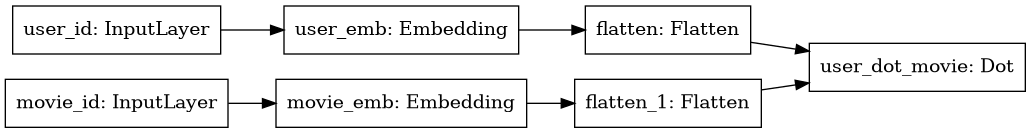

In [11]:
plot_model(movies_cf_r, '/tmp/model.png', rankdir='LR')

In [12]:
movies_cf_r.compile('adam', 'mse')
movies_cf_r_hist = movies_cf_r.fit(
    [X_train['user_id'], X_train['movie_id']], y_train, batch_size=128, epochs=8, validation_split=0.2,
    callbacks=[EarlyStopping(min_delta=0.1, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 24s 8ms/step - loss: 11.1368 - val_loss: 4.4351
Epoch 2/8
3011/3011 [==============================] - 23s 8ms/step - loss: 2.6405 - val_loss: 1.8624
Epoch 3/8
3011/3011 [==============================] - 23s 8ms/step - loss: 1.3413 - val_loss: 1.3029
Epoch 4/8
3011/3011 [==============================] - 24s 8ms/step - loss: 0.9465 - val_loss: 1.0947
Epoch 5/8
3011/3011 [==============================] - 25s 8ms/step - loss: 0.7579 - val_loss: 0.9946
Epoch 6/8
3011/3011 [==============================] - 26s 9ms/step - loss: 0.6459 - val_loss: 0.9349
Epoch 7/8
3011/3011 [==============================] - 23s 8ms/step - loss: 0.5714 - val_loss: 0.8950
Epoch 8/8
3011/3011 [==============================] - 25s 8ms/step - loss: 0.5179 - val_loss: 0.8695


In [13]:
movies_cf_r.save('data/movies_cf_r.h5')
save(movies_cf_r_hist.history, 'data/movies_cf_r_history.pickle')

## Evalueren

In [14]:
movies_cf_r = load_model('data/movies_cf_r.h5')
movies_cf_r_history = load('data/movies_cf_r_history.pickle')

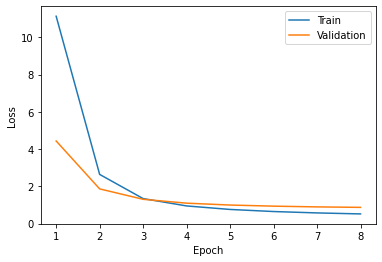

In [15]:
plot_loss(movies_cf_r_history);

In [16]:
y_movies_cf_r_test = movies_cf_r.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_r_train = movies_cf_r.predict([X_train['user_id'], X_train['movie_id']])

In [17]:
print('Test:')
print_rg_report(y_test, y_movies_cf_r_test)
print('Train:')
print_rg_report(y_train, y_movies_cf_r_train)

Test:
MSE = 0.8847522151720113
MAE = 0.6253388016249102
Train:
MSE = 0.5374796789620602
MAE = 0.5291202455084182


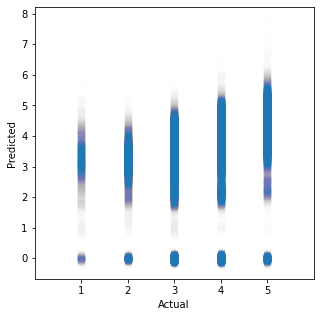

In [18]:
plot_preds(y_test, y_movies_cf_r_test);

Underfitting

# Classificatie

In [19]:
emb_size = 16

user_input = Input(user_dim, name='user_id')
user_emb = chain_layers(
    user_input,
    Embedding(user_voc_size + 1, emb_size, name='user_emb'),
    Flatten()
)
movie_input = Input(movie_dim, name='movie_id')
movie_emb = chain_layers(
    movie_input,
    Embedding(movie_voc_size + 1, emb_size, name='movie_emb'),
    Flatten()
)
user_movie = chain_layers(
    Concatenate()([user_emb, movie_emb]),
    Dense(n_classes, 'softmax')
)
movies_cf_c = Model([user_input, movie_input], user_movie, name='movies_cf_c')

In [20]:
movies_cf_c.summary()

Model: "movies_cf_c"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 16)        113968      user_id[0][0]                    
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 16)        526688      movie_id[0][0]                   
________________________________________________________________________________________

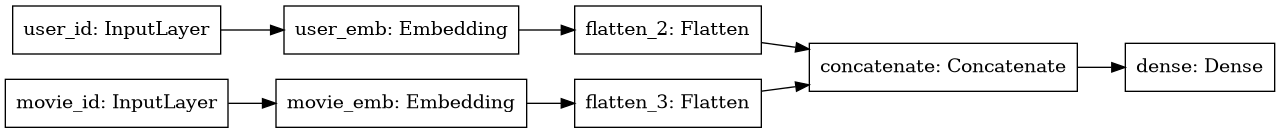

In [21]:
plot_model(movies_cf_c, '/tmp/model.png', rankdir='LR')

In [22]:
movies_cf_c.compile('adam', 'categorical_crossentropy', ['accuracy'])
movies_cf_c_hist = movies_cf_c.fit(
    [X_train['user_id'], X_train['movie_id']], Y_train, batch_size=128, epochs=8, validation_split=0.2,
    callbacks=[EarlyStopping('val_accuracy', min_delta=0.005, patience=3, restore_best_weights=True)]
)

Epoch 1/8
3011/3011 [==============================] - 36s 12ms/step - loss: 1.0169 - accuracy: 0.5700 - val_loss: 0.9186 - val_accuracy: 0.5985
Epoch 2/8
3011/3011 [==============================] - 37s 12ms/step - loss: 0.8755 - accuracy: 0.6213 - val_loss: 0.9131 - val_accuracy: 0.6011
Epoch 3/8
3011/3011 [==============================] - 37s 12ms/step - loss: 0.8464 - accuracy: 0.6334 - val_loss: 0.9181 - val_accuracy: 0.6007
Epoch 4/8
3011/3011 [==============================] - 38s 13ms/step - loss: 0.8279 - accuracy: 0.6409 - val_loss: 0.9251 - val_accuracy: 0.5992


In [23]:
movies_cf_c.save('data/movies_cf_c.h5')
save(movies_cf_c_hist.history, 'data/movies_cf_c_history.pickle')

## Evalueren

In [24]:
movies_cf_c = load_model('data/movies_cf_c.h5')
movies_cf_c_history = load('data/movies_cf_c_history.pickle')

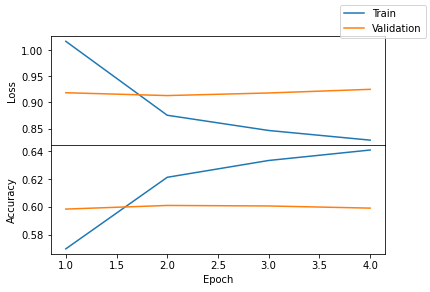

In [25]:
plot_acc(movies_cf_c_history);

In [26]:
Y_movies_cf_c_test = movies_cf_c.predict([X_test['user_id'], X_test['movie_id']])
y_movies_cf_c_test = Y_movies_cf_c_test.argmax(axis=1)
Y_movies_cf_c_train = movies_cf_c.predict([X_train['user_id'], X_train['movie_id']])
y_movies_cf_c_train = Y_movies_cf_c_train.argmax(axis=1)

In [27]:
print('Test:')
print_cl_report(y_test - 1, y_movies_cf_c_test)
print('Train:')
print_cl_report(y_train - 1, y_movies_cf_c_train)

Test:
              precision    recall  f1-score   support

           0       0.27      0.03      0.06      1646
           1       0.32      0.02      0.04      4616
           2       0.57      0.47      0.51     42436
           3       0.60      0.76      0.67     77496
           4       0.63      0.49      0.55     34373

    accuracy                           0.60    160567
   macro avg       0.48      0.36      0.37    160567
weighted avg       0.59      0.60      0.58    160567

Train:
              precision    recall  f1-score   support

           0       0.47      0.05      0.10      4940
           1       0.46      0.04      0.07     13846
           2       0.61      0.51      0.55    127306
           3       0.63      0.79      0.70    232487
           4       0.66      0.53      0.59    103119

    accuracy                           0.63    481698
   macro avg       0.56      0.38      0.40    481698
weighted avg       0.62      0.63      0.61    481698



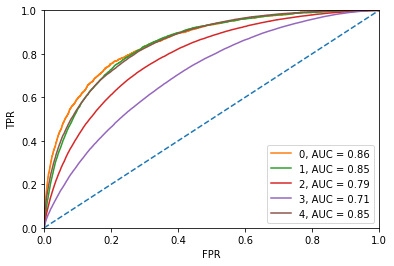

In [28]:
plot_rocc(y_test - 1, Y_movies_cf_c_test);

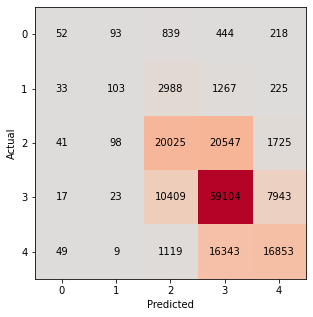

In [29]:
plot_confmat(y_test - 1, y_movies_cf_c_test);

Klassen zijn beoordelingen, i.e., metrics voor regressie kunnen gebruikt worden.

In [30]:
print_rg_report(y_test - 1, y_movies_cf_c_test)

MSE = 0.5545161832755174
MAE = 0.4461377493507383


Underfitting, last van onbalans.